In [430]:
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Add, Lambda




In [432]:
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [433]:
data_path = "/kaggle/input/scaled-sentiment/btc_scaled_features.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
btc_full = pd.read_csv("/kaggle/input/full-sentiment1/btc_full_with_sentiment (2).csv", index_col=0, parse_dates=True)
print("Final feature columns:", btc_full.columns.tolist())
print("Final shape:", btc_full.shape)
print("Final feature columns:", df.columns.tolist())
print("Final shape:", df.shape)

Final feature columns: ['open', 'high', 'low', 'close', 'volume', 'sma_7', 'sma_21', 'ema_7', 'ema_21', 'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff', 'dayofweek', 'month', 'is_weekend', 'tweet_vader_sentiment', 'news_sentiment', 'fear_greed_index']
Final shape: (3759, 19)
Final feature columns: ['open', 'high', 'low', 'close', 'volume', 'sma_7', 'sma_21', 'ema_7', 'ema_21', 'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff', 'dayofweek', 'month', 'is_weekend', 'tweet_vader_sentiment', 'news_sentiment', 'fear_greed_index']
Final shape: (3759, 19)


In [434]:
target_col = 'close'

old_feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'sma_7', 'sma_21', 'ema_7', 'ema_21',
    'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff',
    'dayofweek', 'month', 'is_weekend'
]

new_feature_cols = old_feature_cols + [
    'tweet_vader_sentiment', 'news_sentiment', 'fear_greed_index'
]


In [435]:
def create_sequences(data, target_col_idx, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i][target_col_idx])
    return np.array(X), np.array(y)

sequence_length = 60

scaled_old = df[old_feature_cols]
X_old, y_old = create_sequences(scaled_old.values, old_feature_cols.index(target_col), sequence_length)

scaled_new = df[new_feature_cols]
X_new, y_new = create_sequences(scaled_new.values, new_feature_cols.index(target_col), sequence_length)


In [436]:
def split_data(X, y, train_ratio=0.7, val_ratio=0.1):
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]

    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train_old, y_train_old, X_val_old, y_val_old, X_test_old, y_test_old = split_data(X_old, y_old)

X_train_new, y_train_new, X_val_new, y_val_new, X_test_new, y_test_new = split_data(X_new, y_new)

In [437]:
# def build_lstm(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         LSTM(128, return_sequences=True),
#         LSTM(64),
#         Dense(25),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

# model_lstm_old = build_lstm((X_train_old.shape[1], X_train_old.shape[2]))
# model_lstm_new = build_lstm((X_train_new.shape[1], X_train_new.shape[2]))
# tf.keras.utils.set_random_seed(seed) 

In [438]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label='Model'):
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=100,
        callbacks=[callback],
        verbose=2
    )

    preds = model.predict(X_test).flatten()

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    corr, _ = pearsonr(y_test, preds)

    print(f"🔹 {label} Results:")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} | Pearson Corr: {corr:.4f}")

    return preds, mae, rmse, r2, corr

# preds_lstm_old, mae_old, rmse_old, r2_old, corr_old = train_model(
#     model_lstm_old, X_train_old, y_train_old, X_val_old, y_val_old, X_test_old, y_test_old, label='LSTM (Old Features)'
# )

# preds_lstm_new, mae_new, rmse_new, r2_new, corr_new = train_model(
#     model_lstm_new, X_train_new, y_train_new, X_val_new, y_val_new, X_test_new, y_test_new, label='LSTM (New Features)'
# )


In [439]:
def plot_and_evaluate_usd(y_test_scaled, y_pred_scaled, btc_full_df, feature_cols, scaler, model_name='Model'):
    # Refit the scaler only on btc_model for inverse transform
    btc_model = btc_full_df[feature_cols].copy()
    scaler.fit(btc_model)

    # Build placeholder arrays for inverse transform
    y_test_full = np.zeros((len(y_test_scaled), len(feature_cols)))
    y_test_full[:, feature_cols.index("close")] = y_test_scaled.flatten()

    y_pred_full = np.zeros((len(y_pred_scaled), len(feature_cols)))
    y_pred_full[:, feature_cols.index("close")] = y_pred_scaled.flatten()

    # Inverse transform to get real price values
    y_test_real = scaler.inverse_transform(y_test_full)[:, feature_cols.index("close")]
    y_pred_real = scaler.inverse_transform(y_pred_full)[:, feature_cols.index("close")]

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Actual Price (USD)')
    plt.plot(y_pred_real, label='Predicted Price (USD)')
    plt.title(f"{model_name} - BTC Price Prediction vs Actual (USD)")
    plt.xlabel("Time Step")
    plt.ylabel("BTC Price ($)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/kaggle/working/{model_name}_plot.png')
    plt.show()

    # Evaluate real-world errors
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)
    corr, _ = pearsonr(y_test_real, y_pred_real)

    print(f"📈 {model_name} Evaluation in USD:")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {corr:.4f}")


In [440]:
# plot_and_evaluate_usd(
#     y_test_old, preds_lstm_old,
#     btc_full, old_feature_cols,
#     MinMaxScaler(), model_name='LSTM_Old'
# )


In [441]:
# plot_and_evaluate_usd(
#     y_test_new, preds_lstm_new,
#     btc_full, new_feature_cols,
#     MinMaxScaler(), model_name='LSTM_New'
# )


In [442]:
def build_gru(input_shape):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = Dropout(0.2)(x)
    x = GRU(64)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    # Residual connection (reshape input to match output if needed)
    shortcut = Lambda(lambda z: z[:, -1, 0:1])(inp)  # Use last timestep of 'open' price as residual base
    out = Add()([x, shortcut])

    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model



# Build GRU model for new features (with sentiment)
model_gru_new = build_gru((X_train_new.shape[1], X_train_new.shape[2]))
# tf.keras.utils.set_random_seed(seed) 

# Train and evaluate
preds_gru_new, mae_gru, rmse_gru, r2_gru, corr_gru = train_model(
    model_gru_new,
    X_train_new, y_train_new,
    X_val_new, y_val_new,
    X_test_new, y_test_new,
    label='GRU (New Features)'
)


Epoch 1/100
81/81 - 2s - 29ms/step - loss: 0.0041 - val_loss: 2.0715e-04
Epoch 2/100
81/81 - 1s - 9ms/step - loss: 9.2513e-04 - val_loss: 2.1237e-04
Epoch 3/100
81/81 - 1s - 9ms/step - loss: 5.6503e-04 - val_loss: 2.1342e-04
Epoch 4/100
81/81 - 1s - 9ms/step - loss: 4.7147e-04 - val_loss: 2.1125e-04
Epoch 5/100
81/81 - 1s - 9ms/step - loss: 3.3843e-04 - val_loss: 2.8218e-04
Epoch 6/100
81/81 - 1s - 9ms/step - loss: 3.2440e-04 - val_loss: 1.6373e-04
Epoch 7/100
81/81 - 1s - 9ms/step - loss: 2.6561e-04 - val_loss: 1.7198e-04
Epoch 8/100
81/81 - 1s - 9ms/step - loss: 2.3953e-04 - val_loss: 1.6234e-04
Epoch 9/100
81/81 - 1s - 9ms/step - loss: 2.2106e-04 - val_loss: 1.6332e-04
Epoch 10/100
81/81 - 1s - 9ms/step - loss: 2.0335e-04 - val_loss: 1.5988e-04
Epoch 11/100
81/81 - 1s - 9ms/step - loss: 1.7987e-04 - val_loss: 1.6381e-04
Epoch 12/100
81/81 - 1s - 9ms/step - loss: 1.8394e-04 - val_loss: 1.7200e-04
Epoch 13/100
81/81 - 1s - 9ms/step - loss: 1.8359e-04 - val_loss: 1.5880e-04
Epoch 14/10

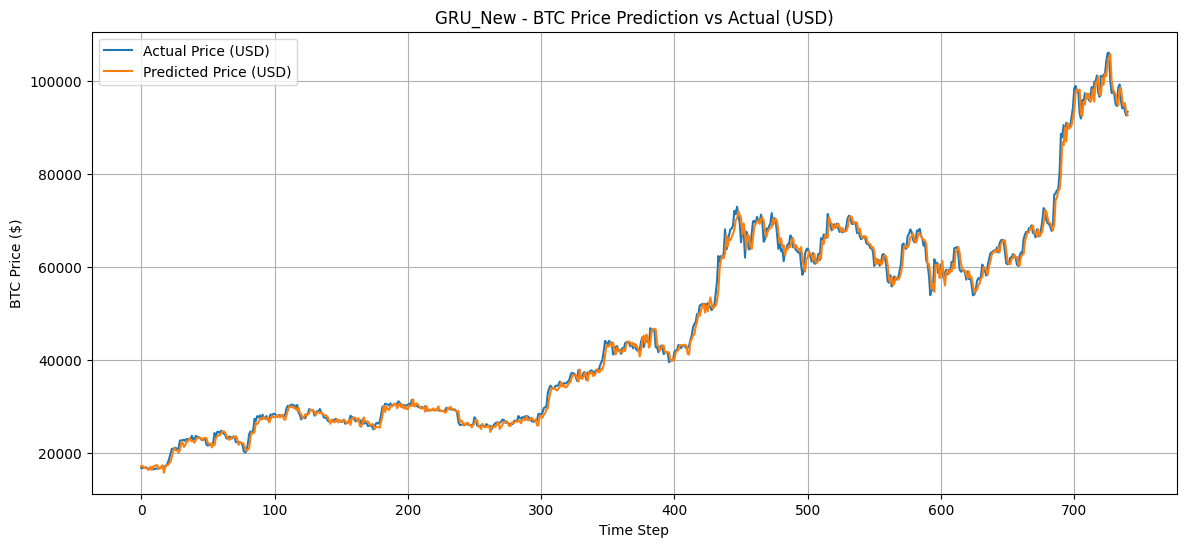

📈 GRU_New Evaluation in USD:
MAE: $1014.06
RMSE: $1504.56
R² Score: 0.9952
Pearson Correlation: 0.9977


In [443]:
plot_and_evaluate_usd(
    y_test_new, preds_gru_new,
    btc_full, new_feature_cols,
    MinMaxScaler(), model_name='GRU_New'
)


In [444]:
# # Step 1: Average predictions from LSTM and GRU (still in scaled form)
# preds_ensemble = (preds_lstm_new + preds_gru_new) / 2

# # Step 2: Use the existing function to inverse scale and plot
# plot_and_evaluate_usd(
#     y_test_new, preds_ensemble,
#     btc_full, new_feature_cols,
#     MinMaxScaler(), model_name='Ensemble_LSTM_GRU'
# )

# # Save ensemble metrics for plotting
# mae_ens = mean_absolute_error(y_test_new, preds_ensemble)
# rmse_ens = np.sqrt(mean_squared_error(y_test_new, preds_ensemble))


In [445]:
# # Automated values from earlier runs
# labels = ['LSTM (Old)', 'LSTM (New)', 'GRU (New)', 'Ensemble']
# maes = [mae_old, mae_new, mae_gru, mae_ens]
# rmses = [rmse_old, rmse_new, rmse_gru, rmse_ens]

# x = np.arange(len(labels))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10, 6))
# bars1 = ax.bar(x - width/2, maes, width, label='MAE ($)', color='skyblue')
# bars2 = ax.bar(x + width/2, rmses, width, label='RMSE ($)', color='salmon')

# # Labels and formatting
# ax.set_ylabel('Error ($)')
# ax.set_title('Model Comparison: MAE vs RMSE (in USD)')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# ax.grid(True, linestyle='--', alpha=0.6)

# # Add values on bars
# for bar in bars1 + bars2:
#     height = bar.get_height()
#     ax.annotate(f'{height:.4f}',
#                 xy=(bar.get_x() + bar.get_width()/2, height),
#                 xytext=(0, 5),
#                 textcoords="offset points",
#                 ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.savefig('/kaggle/working/model_comparison_auto.png')
# plt.show()


In [446]:
# # Inverse transform predictions to real USD values
# scaler = MinMaxScaler()
# btc_model = btc_full[new_feature_cols].copy()
# scaler.fit(btc_model)

# def inverse_single(pred_scaled):
#     full = np.zeros((len(pred_scaled), len(new_feature_cols)))
#     full[:, new_feature_cols.index('close')] = pred_scaled.flatten()
#     return scaler.inverse_transform(full)[:, new_feature_cols.index('close')]

# y_actual = inverse_single(y_test_new)
# y_lstm = inverse_single(preds_lstm_new)
# y_gru = inverse_single(preds_gru_new)
# y_ens = inverse_single(preds_ensemble)

# # Plot
# plt.figure(figsize=(14, 6))
# plt.plot(y_actual, label='Actual Price', color='black')
# plt.plot(y_lstm, label='LSTM Prediction', linestyle='--')
# plt.plot(y_gru, label='GRU Prediction', linestyle='--')
# plt.plot(y_ens, label='Ensemble Prediction', linestyle='-.')

# plt.title("Actual vs Predicted BTC Prices (All Models)")
# plt.xlabel("Time Step")
# plt.ylabel("BTC Price (USD)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('/kaggle/working/combined_predictions.png')
# plt.show()
